In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


# Machine Learning

##  Unsupervised Machine Learning Algorithms

In [2]:
import sys
import os
from time import time
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import TSNE

from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import matplotlib.patheffects as PathEffects

In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('./')

# set location of inputs for this module
moduleDir = './'
# set location of output files
outDir = os.path.join('./')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 7),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1,
          'scatter.edgecolors': 'b' # edge color of markers
         }

CMAP = plt.cm.brg
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('bmh')

TEST_SIZE = 0.2

<Figure size 1500x700 with 0 Axes>

In [4]:
 # Utility function to visualize the outputs of PCA and t-SNE

def digit_scatter(x, labels):
    '''
    Args:
        x: (dimentional data)
        labels : labels of the data
    Returns:
        
    
    '''
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    fig, ax = plt.subplots(figsize=(6, 6))
    
    #ax = plt.subplot(aspect='equal')
    ax.set_aspect('auto')
    
    sc = ax.scatter(x[:,0], x[:,1], s=15, 
                    c=palette[labels.astype(np.int16)], 
                    edgecolors = 'k')
    
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[labels == i, :], axis=0)
        
        txt = ax.text(xtext, ytext, str(i), fontsize=20)
        
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        
        txts.append(txt)

    return

## The Curse of Dimensionality

Handling the high-dimensional data is very difficult in practice, commonly known as the *curse of dimensionality*. If the dimensionality of the input dataset increases, any machine learning algorithm and model becomes more complex. As the number of features increases, the number of samples also gets increased proportionally, and the chance of over-fitting also increases. If the machine learning model is trained on high-dimensional data, it becomes over-fitted and results in poor performance.

Hence, it is often required to reduce the number of features, which can be done with dimensionality reduction.

## Dimensionality Reduction

### PCA

This notebook is part of Introduction to Machine learninig. For further details, please refer http://scikit-learn.org/


<img src='../../images/S04_fig1.png' width='400' alt="PCA Image"/>



The first principal component is the direction of maximum variance in the data. The second principal component is the direction of maximum variance in the space perpendicular (orthogonal) to the first principal component and so on and so forth. The first and second principal components the 2D data are shown above.

We also learned that the first principal component is the $eigenvector$ of the covariance matrix corresponding to the maximum $eigenvalue$. 

The second principal component is the $eigenvector$ corresponding to the second largest $eigenvalue$.

In [5]:
# Note the time of starting
t0= time()

# CSV file name
iris_file = os.path.join(inpDir, moduleDir, 'iris.csv')

# Define feature names

iris_features = ['sepal length',
                 'sepal width',
                 'petal length',
                 'petal width',
                 'target']
# Read the CSV file
iris_df = pd.read_csv(iris_file, sep=',', 
                      skiprows=1, header=None, 
                      names = iris_features)

print ("Read CSV file of shape {} at:{:7.3f} Sec".format(iris_df.shape, 
                                                         (time()-t0)),
       flush = True)


Read CSV file of shape (150, 5) at:  0.016 Sec


In [6]:
iris_df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [7]:
features = iris_df.drop('target',axis=1).to_numpy()
labels = iris_df['target']

num_classes = np.unique(labels)
print ("Features and labels ready at:{:7.3f} mins".format((time()-t0)/60),
           flush = True)

Features and labels ready at:  0.001 mins


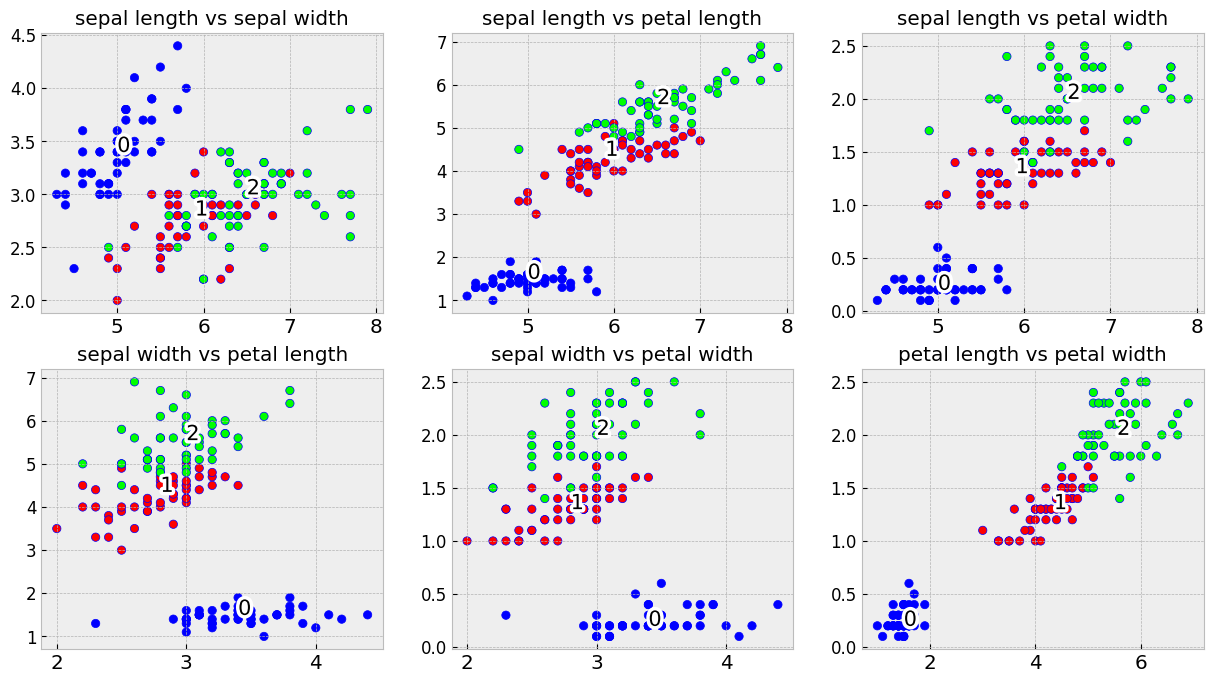

In [8]:
# Plot the features
kk = 1

plt.figure( figsize = (15 , 8) )

for ii in range (features.shape[1]-1):
    
    for jj in range (ii+1, (features.shape[1])):
        
        ax = plt.subplot(2, 3, kk )
        
        kk += 1
         
        ax.scatter( features [ :, ii], features [ :, jj], c = labels)
        
        for i in num_classes:

            # Position of each label at median of data points.

            xtext = np.median(features[labels == i, ii], axis=0)

            ytext = np.median(features[labels == i, jj], axis=0)

            txt = ax.text(xtext, ytext, str(i), fontsize=15)

            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])

        
        ax.set_title('{} vs {}'.format(iris_features[ii], 
                                       iris_features[jj]))
        
        ax.axis('tight')
        
        #plt.legend(loc = 'best')

plt.show()

Probably **Petal Length** *vs.* **Petal Width** gives us best separation. But only after looking at all the features. Can this be automated? Let's try PCA!

Using PCA we can summarize instance with less features. PCA is not selecting some features and discarding the others. Instead, it constructs *'some new'* features to summarize labels. In fact, PCA finds the best possible features, the ones that summarize the labels. PCA looks for features that allow to reconstruct the original features.

In [9]:
# instantiate PCA
pca = PCA(n_components=2) # reducing them to two features

# fit PCA using the features
pca.fit(features)

PCA(n_components=2)

In [10]:
#Principal axis in feature space, representing the directions of maximum variance in the data.
pca.components_

array([[ 0.36158968, -0.08226889,  0.85657211,  0.35884393],
       [ 0.65653988,  0.72971237, -0.1757674 , -0.07470647]])

In [11]:
#Percentage of variance explained by each of the selected components.
pca.explained_variance_ratio_

array([0.92461621, 0.05301557])

In [12]:
pca.explained_variance_ratio_.sum()

0.9776317750248035

In [13]:
#Having fitted the pca we also need to transform...
features_pca = pca.transform(features)

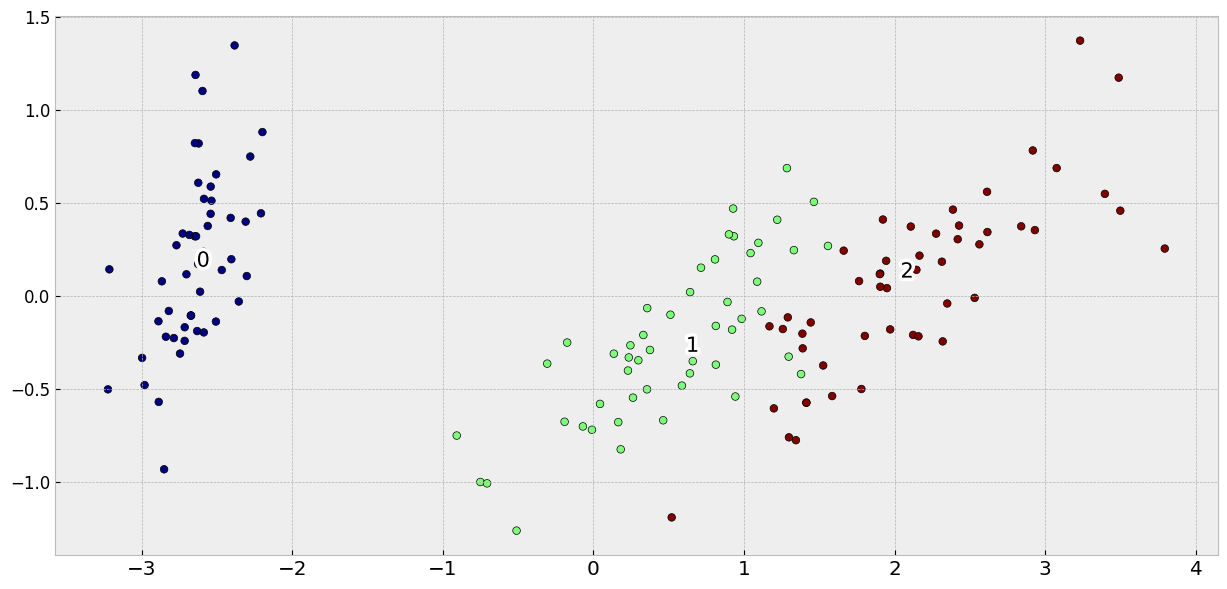

In [14]:
# how it looks?
figure, ax = plt.subplots( )
ax.scatter( features_pca [ :, 0], features_pca [ :, 1], s = 30, c = labels, cmap = plt.cm.jet, ec = 'k')

for i in num_classes:
    
    # Position of each label at median of data points.
    
    xtext = np.median(features_pca[labels == i, 0], axis=0)
    
    ytext = np.median(features_pca[labels == i, 1], axis=0)
    
    txt = ax.text(xtext, ytext, str(i), fontsize=15)
    
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
    
plt.show()

In [15]:
#so where is this data centered around?

print ("Mean = {:s}\n".format(str(np.round(features_pca.mean(axis=0), decimals=5))))

print ("Standard Deviation = {:s}\n".format(str(np.round(features_pca.std(axis=0), decimals=5))))

# Do they have any correlation?? 
print ("Corr Coef. = \n", (np.corrcoef(features_pca.T)))

Mean = [ 0. -0.]

Standard Deviation = [2.04858 0.49054]

Corr Coef. = 
 [[1.00000000e+00 2.35690803e-17]
 [2.35690803e-17 1.00000000e+00]]


### Manifold learning algorithms 
They generally do a better job in recovering the underlying 2-dimensional manifold

In [16]:
## Load Data
from sklearn.datasets import load_digits

digits = load_digits()

X, y = digits.data, digits.target

n_samples, n_features = X.shape

n_neighbors = 30


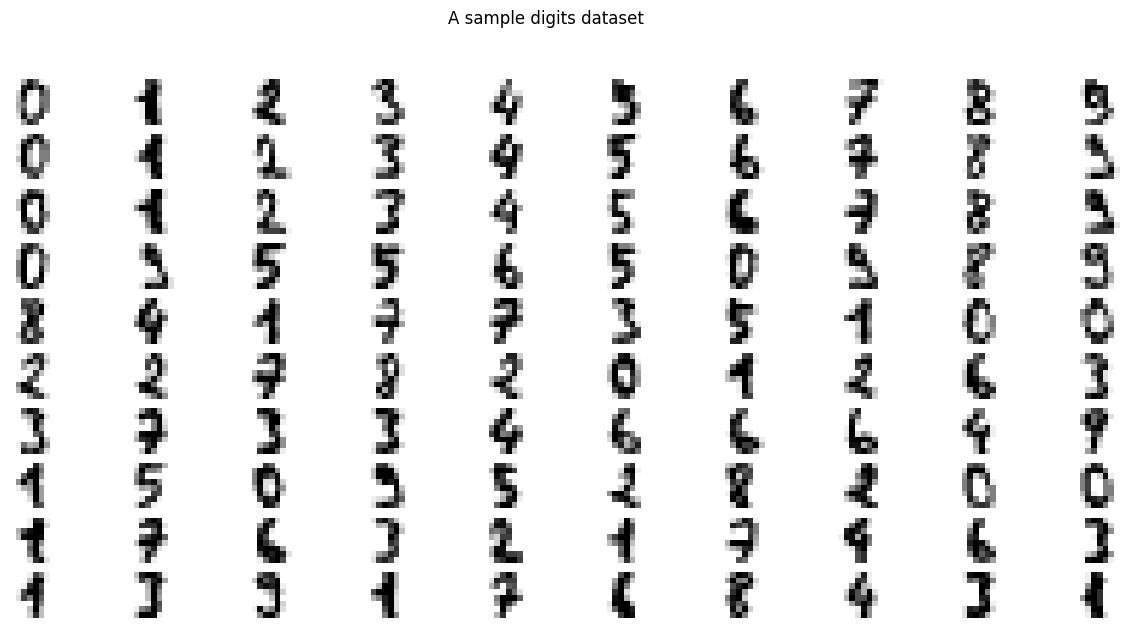

In [17]:
fig, axs = plt.subplots(nrows=10, ncols=10)

for idx, ax in enumerate(axs.ravel()):
    
    ax.imshow(X[idx].reshape((8, 8)), cmap = plt.cm.binary)
    
    ax.axis("off")

_ = fig.suptitle("A sample digits dataset")

In [18]:
sc = StandardScaler()

X_scaled = sc.fit_transform(X)

In [19]:
# first PCA
# instantiate PCA

pca = PCA(n_components=2) # reducing them to two features

projections = pca.fit_transform(X_scaled, y)

print (projections.shape)

(1797, 2)


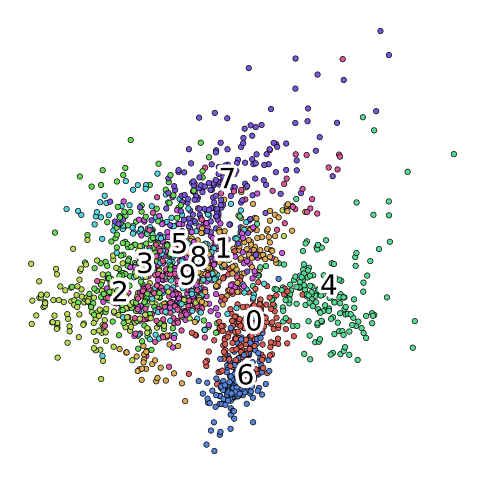

In [20]:
_ = digit_scatter(projections, y)

# Linear Discriminant Analysis embedding

Linear Discriminant analysis is one of the most popular dimensionality reduction techniques used for **supervised classification** problems in machine learning. It is also considered a pre-processing step for modeling differences in ML and applications of pattern classification.

To create a new axis, Linear Discriminant Analysis uses the following criteria:

- It maximizes the distance between means of two classes.
- It minimizes the variance within the individual class.

Using the above two conditions, LDA generates a new axis in such a way that it can maximize the distance between the means of the two classes and minimizes the variation within each class.

In other words, we can say that the new axis will increase the separation between the data points of the two classes and plot them onto the new axis.

#### Extension to Linear Discriminant Analysis (LDA)

It has so many extensions and variations as follows:

- Quadratic Discriminant Analysis (QDA): For multiple input variables, each class deploys its own estimate of variance.
- Flexible Discriminant Analysis (FDA): it is used when there are non-linear groups of inputs are used, such as splines

In [21]:
X_scaled.shape

(1797, 64)

In [22]:
lda = LinearDiscriminantAnalysis( n_components=2    )

data = X_scaled.copy()

data.flat[:: X_scaled.shape[1] + 1] += 0.01  # Make X invertible

projections = lda.fit_transform(data, y)

print (projections.shape)

(1797, 2)


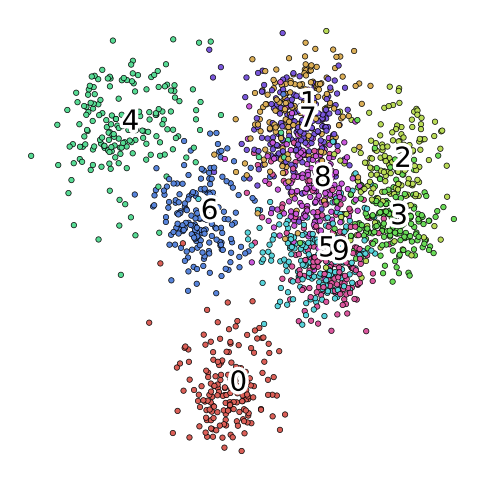

In [23]:
_ = digit_scatter(projections, y)

## t-SNE embedding

PCA is great! It solves most of our problems but not all. It does have some drawbacks. One of the major drawbacks of PCA is that it does not retain non-linear variance. 

(T-distributed Stochastic Neighbor Embedding)
t-SNE is one of the popular dimensionality reduction algorithm and is extensively applied in image processing, NLP, genomic data and speech processing.

t-SNE is non-linear dimensionality reduction algorithm. it finds patterns in the data based on the similarity of data points with features, the similarity of points is calculated as the conditional probability that a point $A$ would choose point $B$ as its neighbor. 

It then tries to minimize the difference between these conditional probabilities (or similarities) in higher-dimensional and lower-dimensional space for a perfect representation of data points in lower-dimensional space. 


In [24]:
tsne = TSNE(
        n_components=2,
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=8,
        random_state=RANDOM_STATE,
    )

projections = tsne.fit_transform(X_scaled, y)

print (projections.shape)

(1797, 2)


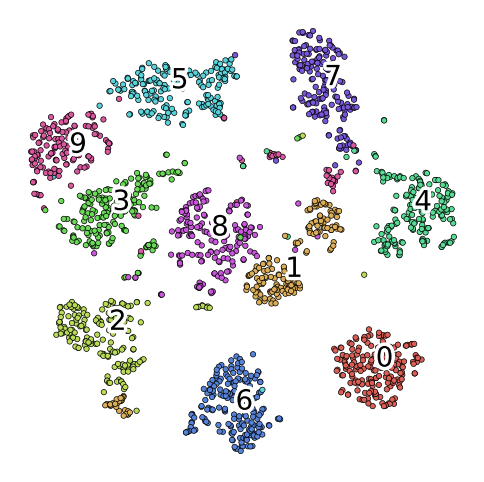

In [25]:
_ = digit_scatter(projections, y)

### others

Refer sklearn [documentation](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py) for other dim reduction techniques. 

## Clustering

Samples having some sort of similarity can be cluster together.

In [26]:
from sklearn.cluster import KMeans

# Apply PCA
pca = PCA ( n_components = 2 ) # reducing them to two components

# fit PCA using the features
features_pca = pca.fit_transform ( X )

kmeans = KMeans(n_clusters = 10, random_state = RANDOM_STATE ) # Note: we need to know expected clusters beforehand
kmeans.fit( features_pca )

# Centers of our clusters
print("Centers :\n", np.round(kmeans.cluster_centers_, decimals=2))

Centers :
 [[-14.32  -6.73]
 [ 15.95  12.96]
 [  4.83  -8.21]
 [-12.16  10.96]
 [ -3.78 -16.55]
 [ 22.69  -0.34]
 [  1.46  21.61]
 [-21.81   6.69]
 [ -3.44   0.25]
 [  9.09 -19.77]]


c:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### With K Means Labels

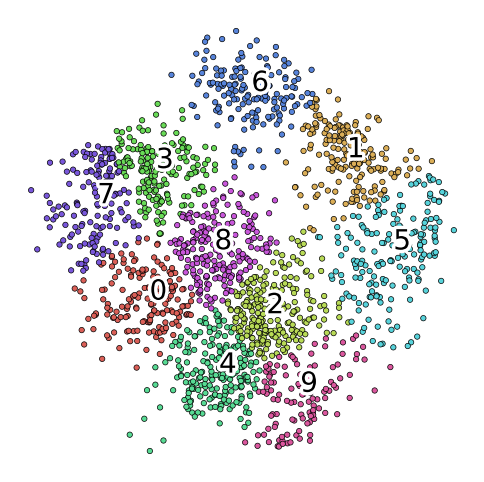

In [27]:
_ = digit_scatter(features_pca, kmeans.labels_)

### Original Labels

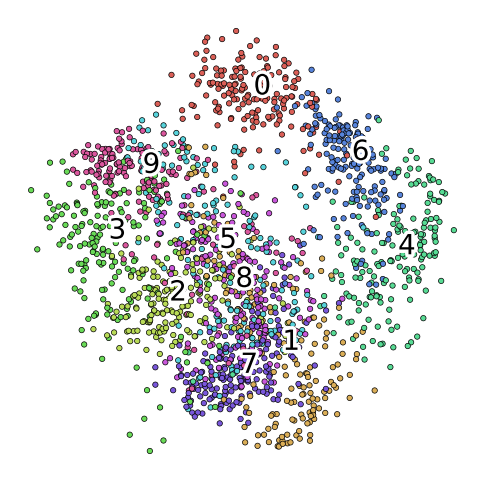

In [28]:
_ = digit_scatter(features_pca, y)

In [29]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [30]:
num_classes = len(np.unique(y))
palette = np.array(sns.color_palette("hls", num_classes))

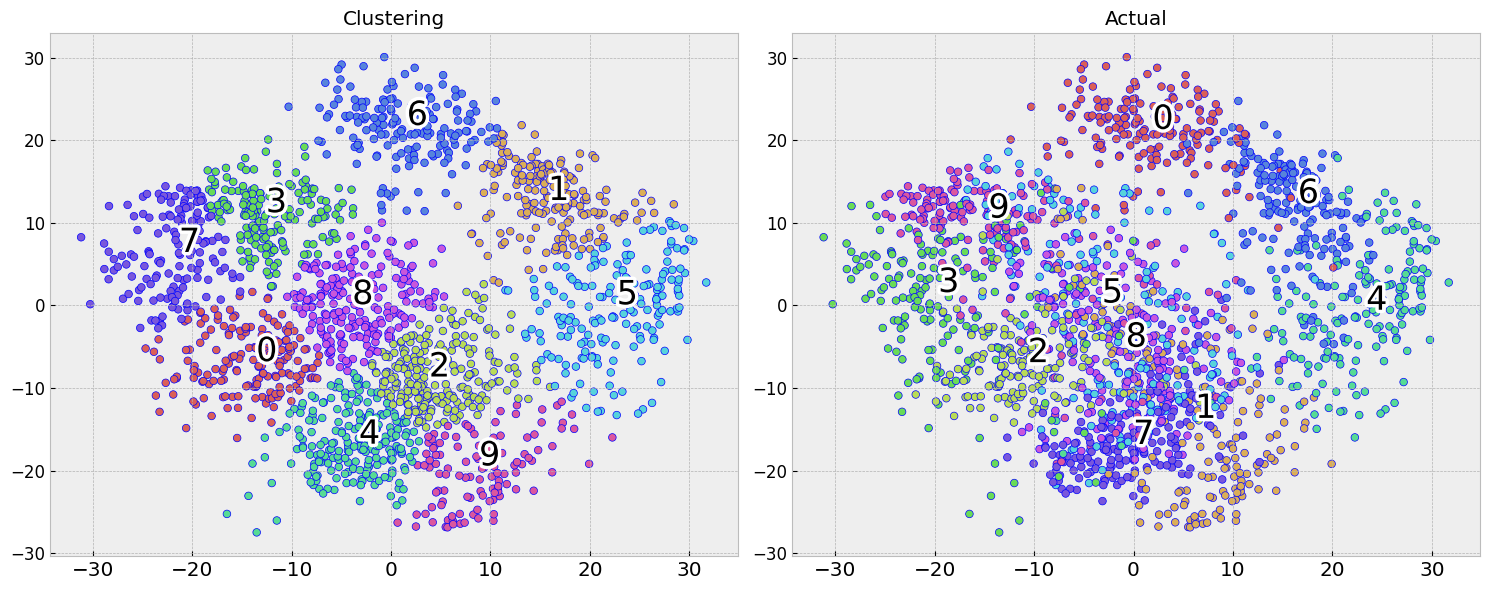

In [31]:
fig, axes = plt.subplots(1,2,  figsize = (15 , 6) )

ax = axes[0]

ax.scatter( features_pca [ :, 0], features_pca [ :, 1],
            c=palette[kmeans.labels_.astype(np.int16)] ,  s = 30 )

for i in np.unique(kmeans.labels_):

        # Position of each label at median of data points.

        xtext, ytext = np.median(features_pca[kmeans.labels_ == i, :], 
                                 axis=0)
        
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])

ax.set_title('Clustering')

ax = axes[1]

ax.scatter( features_pca [ :, 0], features_pca [ :, 1], 
            c=palette[y.astype(np.int16)] , s = 30 )

for i in np.unique(y):

        # Position of each label at median of data points.

        xtext, ytext = np.median(features_pca[y == i, :], axis=0)
        
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])


ax.set_title('Actual')

#plt.savefig('../images/clustering.jpg')

plt.tight_layout()
plt.show()

**K-means** is simplest clustering algorithms, K-means. It finds out required cluster centers such that the distance from each point to its cluster is minimized.

K-means works best where all clusters have equal, spherical variance. In the case of the digits dataset this assumption almost match the geometry of the classes, yet some of the points are not marked properly.

**Gaussian Mixture Models (GMM)** can be used to avoid the assumptions of equal variance or of sphericality.

In [32]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture ( n_components = 10, covariance_type = 'tied' )

gmm.fit( features_pca )

gmm.means_

array([[  7.81822334, -19.93566139],
       [  1.22663788,  21.36696792],
       [-14.67909094,  -5.89982752],
       [ 15.28301461,  13.28697726],
       [-16.99476295,   9.33188539],
       [ -3.35003297, -16.30530261],
       [  2.73872718,  -8.26004417],
       [ 18.91396535,  -6.3241311 ],
       [ -4.15490491,   1.30414616],
       [ 23.45341949,   3.70795391]])

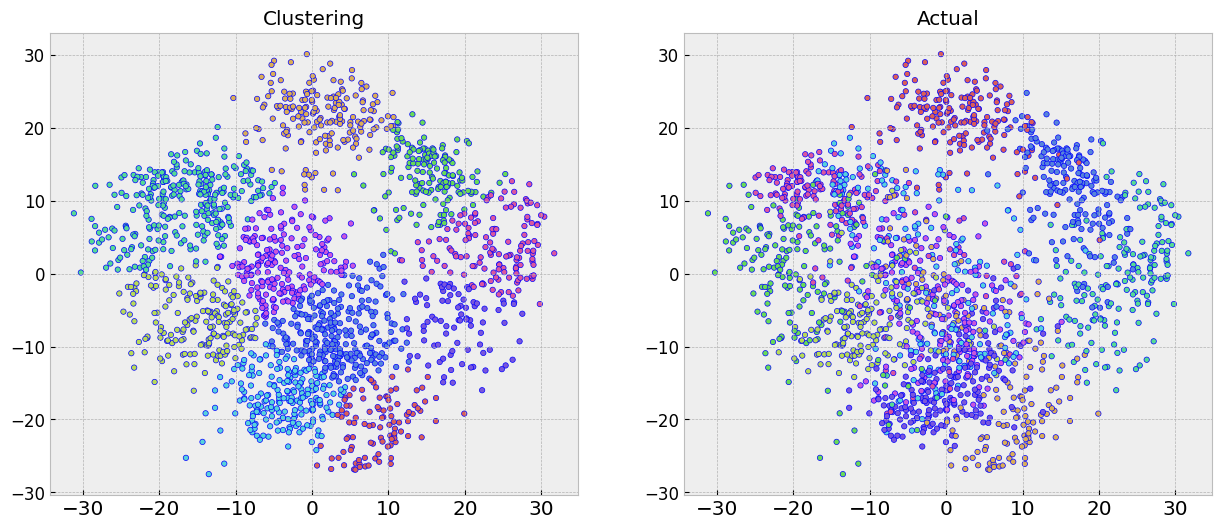

In [33]:
pred = gmm.predict(features_pca)
plt.figure( figsize = (15 , 6) )
plt.subplot( 121 )
plt.subplots_adjust ( wspace = 0.2, hspace = 0.2 )
plt.scatter( features_pca [ :, 0], features_pca [ :, 1], 
            c = palette[pred.astype(np.int16)] , s = 15 )
plt.title( 'Clustering' )

plt.subplot( 122 )
plt.subplots_adjust( wspace = 0.2, hspace = 0.2 )
plt.scatter( features_pca [ :, 0], features_pca [ :, 1], 
            c = palette[y.astype(np.int16)] , s = 15 )
plt.title('Actual')

plt.show()

##  Standardization
Standardization of datasets is a common requirement for many machine learning estimators implemented in the scikit; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

### Scaling vs Whitening
It is sometimes not enough to center and scale the features independently, since a downstream model can further make some assumption on the linear independence of the features.
To address this issue you can use `sklearn.decomposition.PCA` or `sklearn.decomposition.RandomizedPCA` with `whiten=True` to further remove the linear correlation across features.

Original mean:
 [5.84333333 3.054      3.75866667 1.19866667]
Mean after Scaling:
 [-4.73695157e-16 -6.63173220e-16  3.31586610e-16 -2.84217094e-16]
---------------------
Original std:
 [0.82530129 0.43214658 1.75852918 0.76061262]
Std after Scaling:
 [1. 1. 1. 1.]


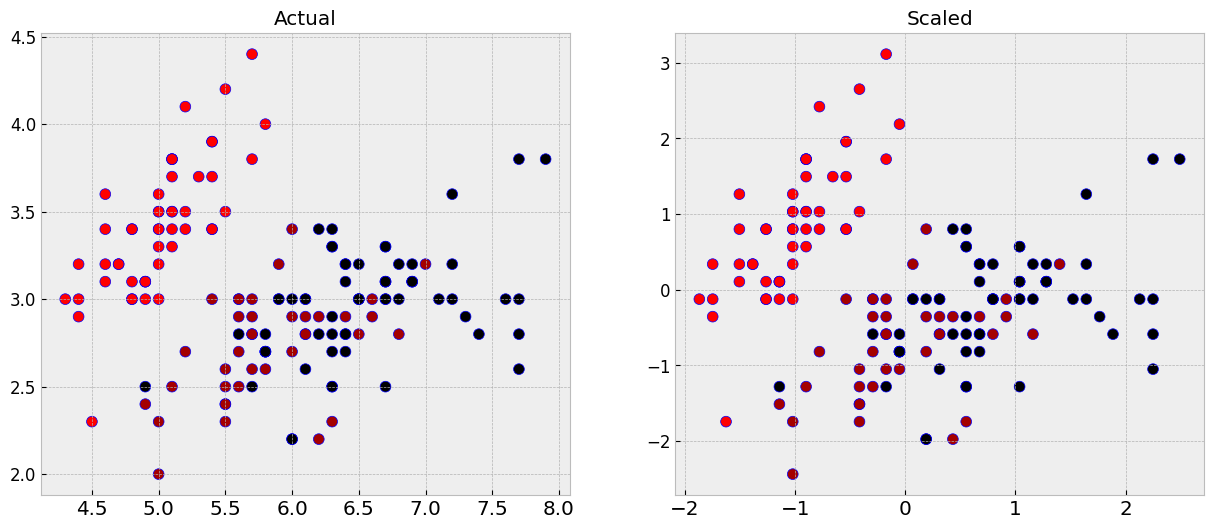

In [34]:
from sklearn.preprocessing import scale

features_scaled = scale(features)

plt.figure( figsize = (15 , 6) )
plt.subplot(121)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.scatter( features [ :, 0], features [ :, 1], c = labels, cmap = plt.cm.flag, s = 60 )
plt.title('Actual')

plt.subplot(122)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.scatter( features_scaled [ :, 0], features_scaled [ :, 1], c = labels , cmap = plt.cm.flag , s = 60 )
plt.title('Scaled')
#plt.savefig('images/scale.jpg')


print ("Original mean:\n",features.mean(axis=0) )
print ("Mean after Scaling:\n", features_scaled.mean(axis=0))
print ("---------------------")
print ("Original std:\n",features.std(axis=0) )
print ("Std after Scaling:\n", features_scaled.std(axis=0))

plt.show()

Original mean:
 [5.84333333 3.054      3.75866667 1.19866667]
Original values are retained:
 [5.84333333 3.054      3.75866667 1.19866667]
Mean after Scaling:
 [-4.73695157e-16 -6.63173220e-16  3.31586610e-16 -2.84217094e-16]
---------------------
Original std:
 [0.82530129 0.43214658 1.75852918 0.76061262]
Original values are retained:
 [0.82530129 0.43214658 1.75852918 0.76061262]
Std after Scaling:
 [1. 1. 1. 1.]


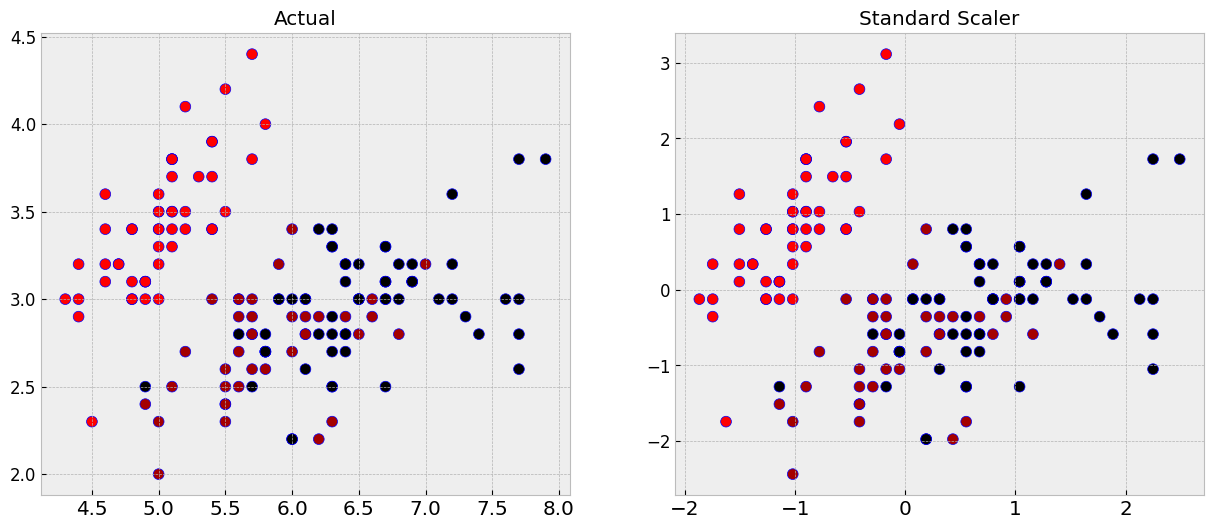

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)

features_scaled = scaler.fit_transform(features)

plt.figure( figsize = (15 , 6) )
plt.subplot(121)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.scatter( features [ :, 0], features [ :, 1], c = labels, cmap = plt.cm.flag, s = 60 )
plt.title('Actual')

plt.subplot(122)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.scatter( features_scaled [ :, 0], features_scaled [ :, 1], c = labels , cmap = plt.cm.flag , s = 60 )
plt.title('Standard Scaler')
#plt.savefig('images/standard_scale.jpg')

print ("Original mean:\n",features.mean(axis=0) )
print ("Original values are retained:\n", scaler.mean_)
print ("Mean after Scaling:\n", features_scaled.mean(axis=0))
print ("---------------------")
print ("Original std:\n",features.std(axis=0) )
print ("Original values are retained:\n", scaler.scale_)
print ("Std after Scaling:\n", features_scaled.std(axis=0))

plt.show()

Original mean:
 [5.84333333 3.054      3.75866667 1.19866667]
Mean after Scaling:
 [0.4287037  0.43916667 0.46757062 0.45777778]
---------------------
Original std:
 [0.82530129 0.43214658 1.75852918 0.76061262]
Std after Scaling:
 [0.22925036 0.18006108 0.29805579 0.31692192]


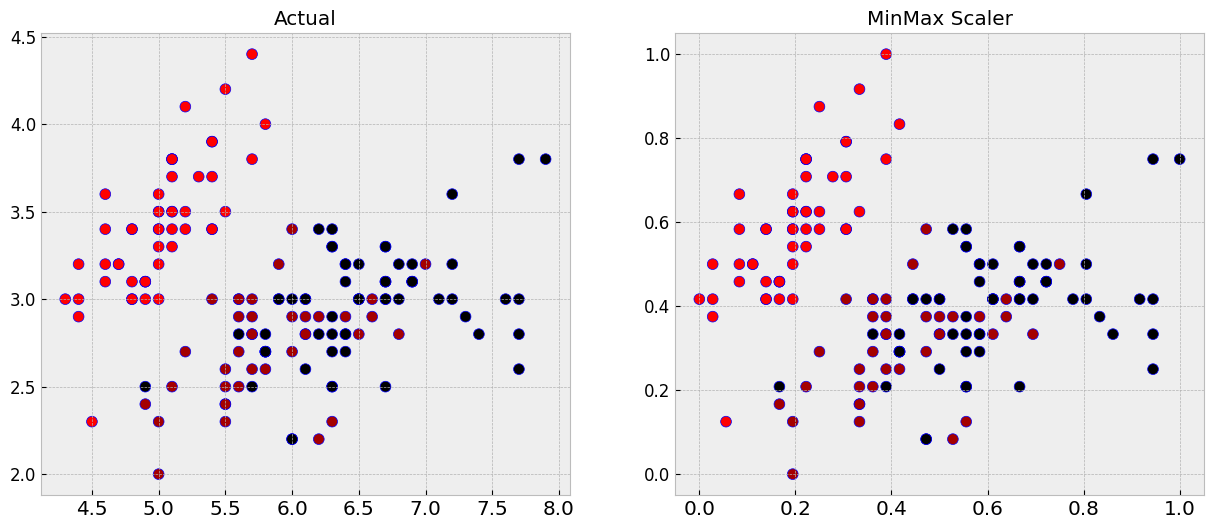

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

features_scaled = scaler.fit_transform(features)

plt.figure( figsize = (15 , 6) )
plt.subplot(121)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.scatter( features [ :, 0], features [ :, 1], c = labels, cmap = plt.cm.flag, s = 60 )
plt.title('Actual')

plt.subplot(122)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.scatter( features_scaled [ :, 0], features_scaled [ :, 1], c = labels , cmap = plt.cm.flag , s = 60 )
plt.title('MinMax Scaler')
#plt.savefig('images/min_max_scale.jpg')

print ("Original mean:\n",features.mean(axis=0) )
print ("Mean after Scaling:\n", features_scaled.mean(axis=0))
print ("---------------------")
print ("Original std:\n",features.std(axis=0) )

print ("Std after Scaling:\n", features_scaled.std(axis=0))

plt.show()

## Feature Selection

### Univariate feature selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. Scikit-learn exposes feature selection routines as objects that implement the transform method:
- SelectKBest removes all but the k highest scoring features
- SelectPercentile removes all but a user-specified highest scoring percentage of features
- using common univariate statistical tests for each feature: false positive rate SelectFpr, false discovery rate SelectFdr, or family wise error SelectFwe.
- GenericUnivariateSelect allows to perform univariate feature
    - selection with a configurable strategy. This allows to select the best univariate selection strategy with hyper-parameter search estimator.

The Chi-square($\chi^2$) test is intended to test how likely it is that an observed distribution is due to chance. Also called  a *goodness of fit* statistic, because it measures how well the observed distribution of data fits with the distribution that is expected if the variables are independent. 

Only for categorical data, will not work with parametric or continuous data, We can select 2 best features from iris dataset as follows:


In [37]:
from sklearn.feature_selection import SelectKBest, chi2
features_new = SelectKBest(chi2, k=2).fit_transform(features, labels)
features_new.shape

(150, 2)

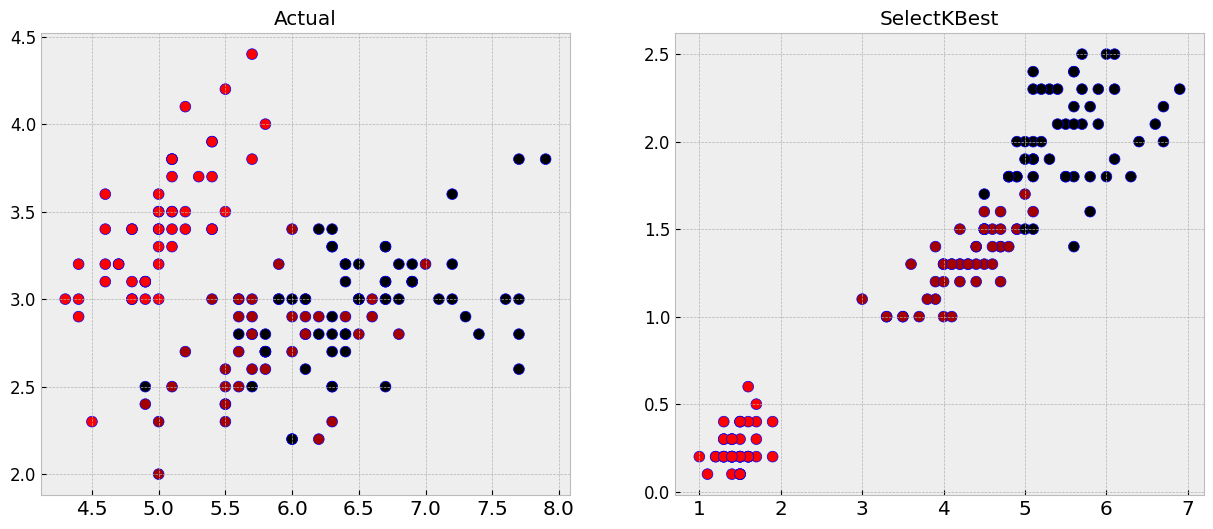

In [38]:
fig, axes = plt.subplots(1,2, figsize =(15,6))

ax = axes[0]

ax.scatter( features [ :, 0], features [ :, 1], c = labels, cmap = plt.cm.flag, s = 60 )
ax.set_title('Actual')

ax = axes[1]

ax.scatter( features_new [ :, 0], features_new [ :, 1], c = labels, cmap = plt.cm.flag, s = 60 )
ax.set_title('SelectKBest');

## SelectPercentile
We will use Selection percentile on digits data.

c:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 0 32 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\prana\AppData\Local\Temp\ipykernel_12640\2003851885.py:24: RuntimeWarning: divide by zero encountered in divide
  scores /= scores.max()
C:\Users\prana\AppData\Local\Temp\ipykernel_12640\2003851885.py:24: RuntimeWarning: invalid value encountered in divide
  scores /= scores.max()


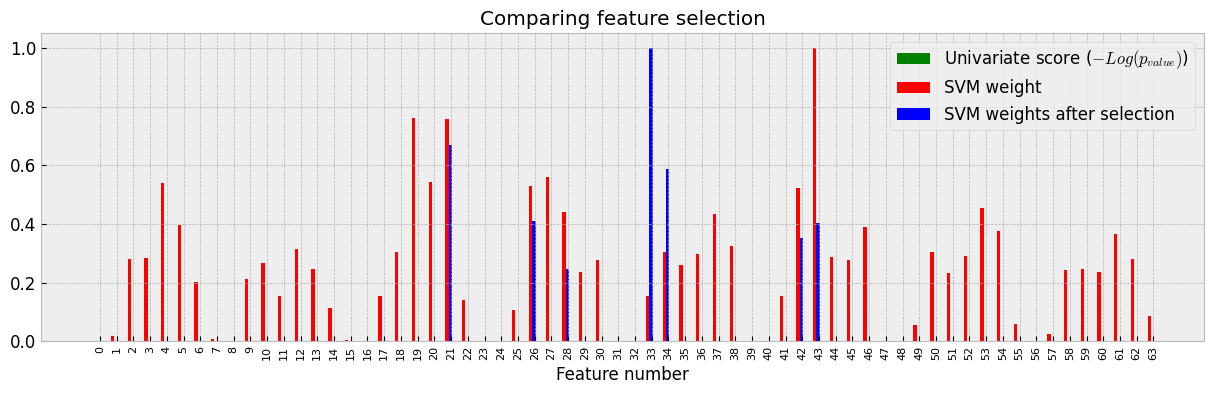

In [39]:
from sklearn import datasets, svm
from sklearn.feature_selection import SelectPercentile, f_classif
from matplotlib import gridspec


plt.figure(figsize = (15,4))

plt.clf()

plt.subplots_adjust(wspace=0.25, hspace=0.25)

X_indices = np.arange(X.shape[-1])

# Univariate feature selection with F-test for feature scoring
# We use the default selection function: the 10% most significant features
selector = SelectPercentile(f_classif, percentile = 10)
selector.fit(X, y)
scores = -np.log1p(selector.pvalues_)

# we may get a few nan and inf the in scores.
scores[np.isnan(scores)] = 0
scores[np.isinf(scores)] = 0 # I would argue that it should be a high number.

scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
       label=r'Univariate score ($-Log(p_{value})$)', color='g')

# Compare to the weights of an SVM
clf = svm.SVC(kernel='linear')
clf.fit(X, y)

svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight', color='r')

clf_selected = svm.SVC(kernel='linear')
clf_selected.fit(selector.transform( X ) , y )

svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='b')


plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.xticks(X_indices, fontsize = 8, rotation=90)
plt.axis('tight')
plt.legend(loc='upper right');

In [40]:
X.shape

(1797, 64)

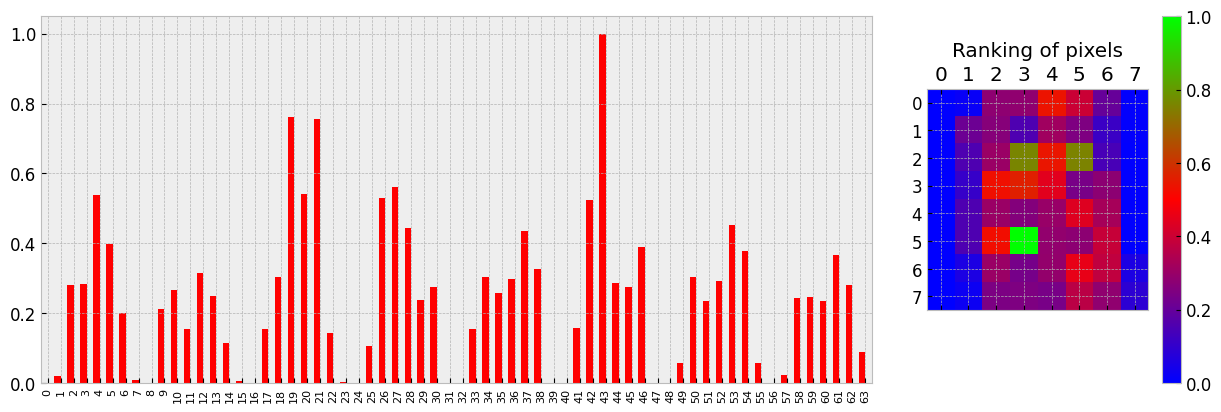

In [41]:
plt.figure(figsize = (15,10))

plt.clf()

plt.subplots_adjust(wspace=0.1, hspace=0.1)
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])

ax0.bar(X_indices-.25, svm_weights, width=.5, label='SVM weight', color='r')
plt.xticks(X_indices, fontsize = 8, rotation=90)
axes = plt.gca()
axes.set_xlim([X_indices.min()-.5,X_indices.max()+.5])



ax1 = plt.subplot(gs[1])

ranking = svm_weights.reshape(8,8)

image = ax1.matshow(ranking)

plt.colorbar(image)

plt.title("Ranking of pixels");

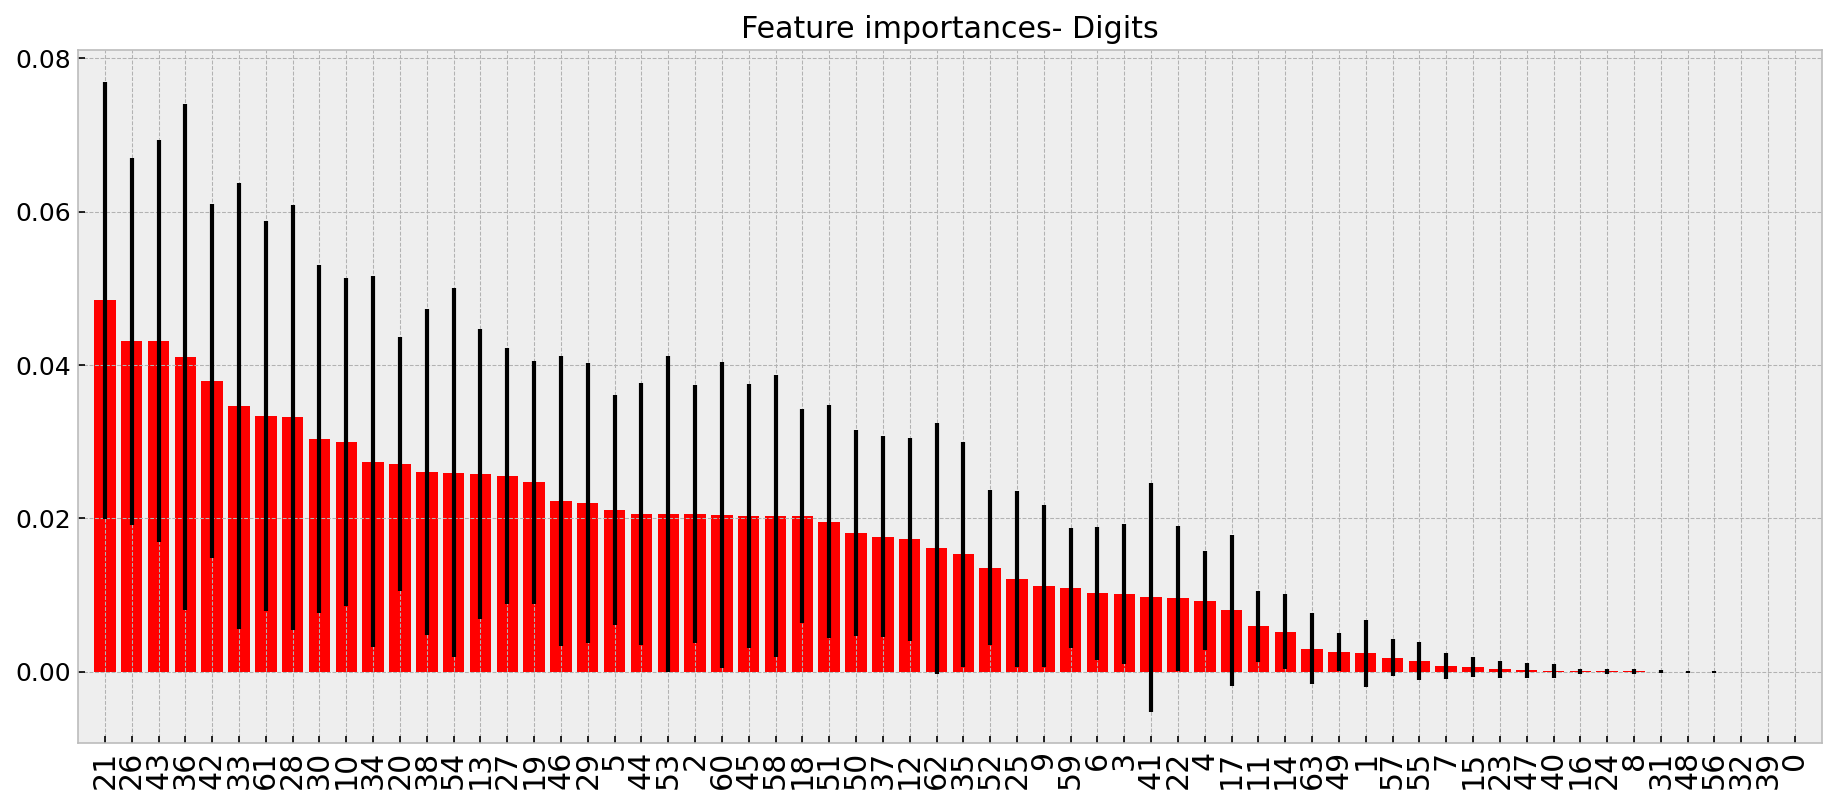

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

clf = svm.SVC(kernel='linear')
clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

rf = RandomForestClassifier()
rf.fit(X,y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

n_cols = 64
plt.figure( figsize = ( 15, 6), dpi = 150)
plt.title('Feature importances- Digits')
#for jj in range (0 , 26):
    #ax = plt.subplot(3, 3, jj)
plt.bar(range(n_cols), importances[indices[:n_cols]], 
        color = "r", yerr = std[indices[:n_cols]], align = "center")
plt.xticks(range(n_cols), indices[:n_cols])
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.xlim([-1, n_cols])

#fig.subplots_adjust(left=.02, right=.98)
plt.show()